# Visualise Hi-C changes!

## Load all the important things

In [100]:
import sys
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.ndimage import rotate
from skimage.transform import resize
import hicstraw
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from HiSiNet.HiCDatasetClass import HiCDataset, HiCDatasetDec, SiameseHiCDataset, PairOfDatasets
from HiSiNet.reference_dictionaries import reference_genomes
from HiSiNet import models
from matplotlib.ticker import MultipleLocator
import pickle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Set seed
random.seed(100)

#### PAXIP1

In [2]:
# load some variables

# Load feature maps
paxip_features_supcon=HiCDatasetDec.load('/home/tt920/HiTwinFormer/feature_maps/paxip_features_supcon_lenet.fmlhic')

# Load Hi-C files 
hic_files = {
    "KO": [
        ("CD69negDPPaxip1KOR1", "data/CD69negDPPaxip1KOR1.hic"),
        ("CD69negDPPaxip1KOR2", "data/CD69negDPPaxip1KOR2.hic"),
    ],
    "WT": [
        ("CD69negDPWTR3", "data/CD69negDPWTR3.hic"),
        ("CD69negDPWTR4", "data/CD69negDPWTR4.hic"),
    ]
}

# Load mlhic files
mlhic_paths = [
    "/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386026_hic_d4_ctl_rep1_chr.mlhic",
    "/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386027_hic_d4_ctl_rep2_chr.mlhic",
    "/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386028_hic_d4_aux_rep1_chr.mlhic",
    "/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386029_hic_d4_aux_rep2_chr.mlhic"
]
mlhic_dataset = [HiCDataset.load(p) for p in mlhic_paths]

# Define model checkpoint
model_checkpoint = "model_outputs/SLeNet_None_0.01_128_supcon_30004_2_aug.ckpt"

reference_genome = "mm9"

filter_index=["all"]

In [ ]:
# Extract features 
paxip_supcon_different_filter_features = []
for nfilter in filter_index:
    currfeatures = []
    for chromosome in paxip_features_supcon.paired_maps.keys():
        if paxip_features_supcon.paired_maps[chromosome] is None: continue
        currfeatures.extend(paxip_features_supcon.extract_features(chromosome, nfilter, "conditions", qthresh=0.96))
    paxip_supcon_different_filter_features.append(currfeatures)

In [ ]:
# Optionally save the extracted features as they take some minutes to create
with open("paxip_supcon_features.pkl", "wb") as f:
    pickle.dump(paxip_supcon_different_filter_features, f)

In [106]:
# If opening premade features: 
with open("paxip_supcon_features.pkl", "rb") as f:
    paxip_supcon_different_filter_features = pickle.load(f)

#### CTCF NPC

In [ ]:
# load some variables

# Load feature maps
paxip_features_supcon=HiCDatasetDec.load('/home/tt920/HiTwinFormer/feature_maps/paxip_features_supcon_lenet.fmlhic')

# Load Hi-C files 
hic_files = {
    "KO": [
        ("CD69negDPPaxip1KOR1", "data/CD69negDPPaxip1KOR1.hic"),
        ("CD69negDPPaxip1KOR2", "data/CD69negDPPaxip1KOR2.hic"),
    ],
    "WT": [
        ("CD69negDPWTR3", "data/CD69negDPWTR3.hic"),
        ("CD69negDPWTR4", "data/CD69negDPWTR4.hic"),
    ]
}

# Load mlhic files
mlhic_paths = [
    "/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386026_hic_d4_ctl_rep1_chr.mlhic",
    "/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386027_hic_d4_ctl_rep2_chr.mlhic",
    "/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386028_hic_d4_aux_rep1_chr.mlhic",
    "/home/tt920/mnt/scratch/tt920/mlhic/all_GSM4386029_hic_d4_aux_rep2_chr.mlhic"
]
mlhic_dataset = [HiCDataset.load(p) for p in mlhic_paths]

# Define model checkpoint
model_checkpoint = "model_outputs/SLeNet_None_0.01_128_supcon_30004_2_aug.ckpt"

reference_genome = "mm9"

filter_index=["all"]

## Embedding distance plot

Loading model from: model_outputs/SLeNet_None_0.01_128_supcon_30004_2_aug.ckpt
Found 3657 samples for chromosome chr2
Total samples in subset dataset: 3657
Running model inference...
  Processing batch 1/37
  Processing batch 11/37
  Processing batch 21/37
  Processing batch 31/37
Processing genomic positions...
Created DataFrame with 819168 rows
Found 819168 rows for chr2
Subsampling every 10 positions for plotting...
Selected 81921 positions for plotting


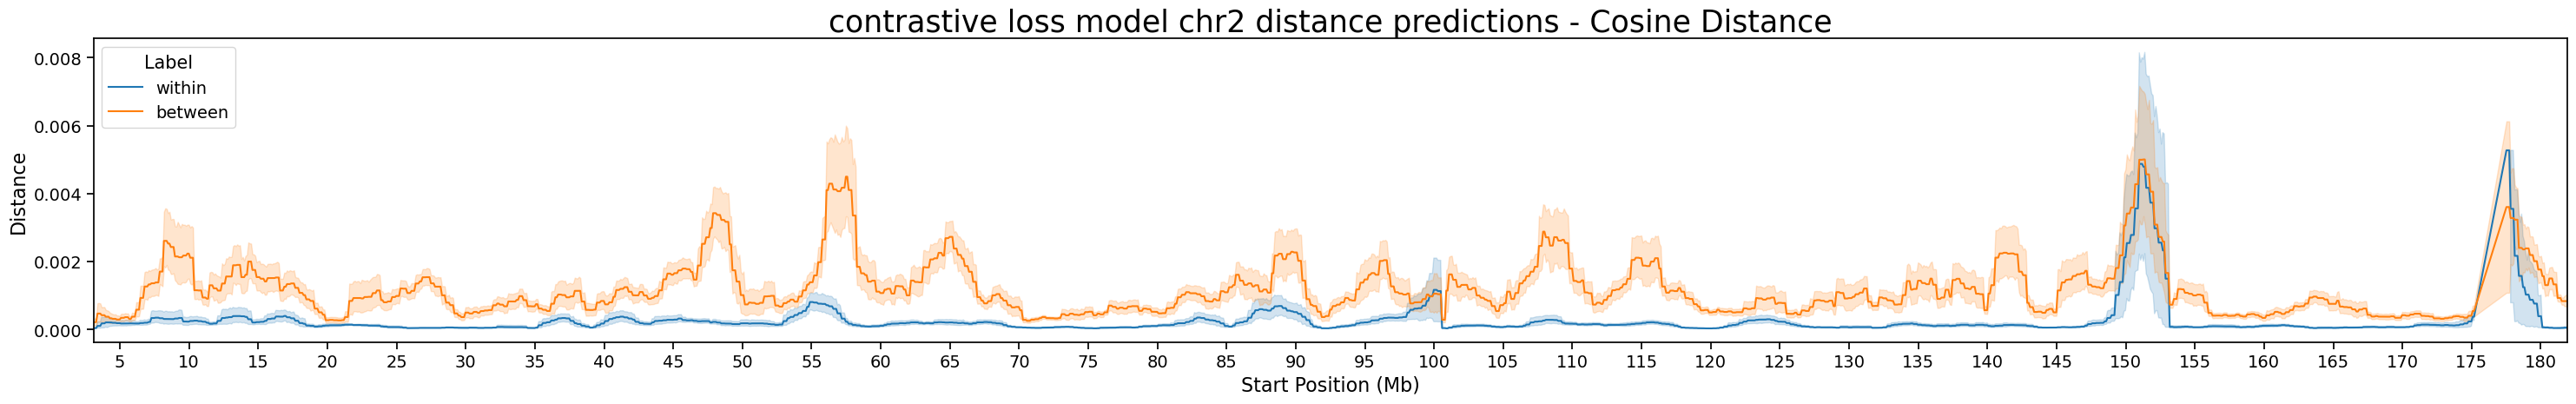

Plot completed!


In [97]:
plot_chromosome_distances(
    mlhic_dataset=mlhic_dataset,                      
    model_ckpt_path=model_checkpoint,
    reference_genome = "mm9",    
    target_chrom="chr2",
    loss_function = "contrastive",
    distance_measure="cosine")                 

In [96]:
def plot_chromosome_distances(
    mlhic_dataset,
    model_ckpt_path,
    reference_genome,
    target_chrom="chr2",
    loss_function="contrastive",
    distance_measure="pairwise",
    mb_start=None,
    mb_end=None,
    bin_size=10000,
    patch_len=224,
    position_stride=10,
    batch_size=100,
    figsize=(30, 5),
    title=None,
    major_tick_interval=5,
    font_scale=1.5
):
    """
    Plot chromosome-wide embedding distances from a Siamese Hi-C model.
    
    Parameters:
    -----------
    mlhic dataset : list
        List of loaded mlhic
    model_ckpt_path : str
        Path to trained Siamese model checkpoint
    reference_genome : dict
        Reference genome dictionary (e.g., reference_genomes["mm9"])
    target_chrom : str, default "chr2"
        Target chromosome to plot
    mb_start : float, optional
        Start position in Mb. If None, starts from chromosome beginning.
    mb_end : float, optional
        End position in Mb. If None, goes to chromosome end.
    loss_function : str
        list loss function for title generation
    distance_measure : str, default "pairwise"
        Distance measure: "pairwise" or "cosine"
    bin_size : int, default 10000
        Hi-C resolution in bp
    patch_len : int, default 224
        Model patch length in bins
    position_stride : int, default 10
        Subsampling stride for plotting
    batch_size : int, default 100
        Batch size for model inference
    figsize : tuple, default (30, 5)
        Figure size (width, height)
    title : str, optional
        Plot title. If None, uses default based on distance measure.
    major_tick_interval : float, default 5
        Major tick interval in Mb for x-axis
    font_scale : float, default 1.5
        Seaborn font scale
"""
    
    # Set seaborn context
    sns.set_context("notebook", font_scale=font_scale)
    
    print(f"Loading model from: {model_ckpt_path}")
    
    # --- Load model ---
    model = models.SLeNet(mask=True)
    model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device("cpu")))
    model.eval()
    
    # --- Load data and subset by chromosome ---
    siamese = SiameseHiCDataset(mlhic_dataset, reference=reference_genomes[reference_genome])
    
    # Add chromosome subsetting functionality
    def normalize_chrom(chrom):
        """Strip 'chr' if present to normalize chromosome names."""
        return chrom[3:] if chrom.startswith("chr") else chrom
    
    def subset_by_chromosome(dataset, target_chrom):
        # Normalize the target too
        target_chrom_norm = normalize_chrom(target_chrom)
        indices = [
            i for i, (_, chrom) in enumerate(dataset.pos)
            if normalize_chrom(chrom) == target_chrom_norm
        ]
        print(f"Found {len(indices)} samples for chromosome {target_chrom}")
        return Subset(dataset, indices)
    
    # Subset the dataset by target chromosome
    from torch.utils.data import Subset
    siamese_subset = subset_by_chromosome(siamese, target_chrom)
    dataloader = DataLoader(siamese_subset, batch_size=batch_size, sampler=SequentialSampler(siamese_subset))
    
    print(f"Total samples in subset dataset: {len(siamese_subset)}")
    
    # --- Test model function ---
    def test_model(model, dataloader, patch_len=224):
        """Test Siamese model and return distances"""
        all_distances = []
        all_labels = []
        print("Running model inference...")
        
        for batch_idx, (x1, x2, y) in enumerate(dataloader):
            if batch_idx % 10 == 0:
                print(f"  Processing batch {batch_idx + 1}/{len(dataloader)}")
            
            y = y.float()
            with torch.no_grad():
                o1, o2 = model(x1, x2)
                if distance_measure.lower() == "cosine":
                    dists = 1 - F.cosine_similarity(o1, o2)
                elif distance_measure.lower() == "pairwise":
                    dists = F.pairwise_distance(o1, o2)
                else:
                    raise ValueError(f"Unknown distance measure: {distance_measure}")
            
            # Expand each distance/label for all bins in the patch
            expanded_dists = np.repeat(dists.cpu().numpy(), patch_len)
            expanded_labels = np.repeat(y.cpu().numpy(), patch_len)
            all_distances.append(expanded_dists)
            all_labels.append(expanded_labels)
        
        return np.concatenate(all_distances), np.concatenate(all_labels)
    
    # --- Run model testing ---
    distances, labels_siam = test_model(model, dataloader, patch_len=patch_len)
    
    print("Processing genomic positions...")
    
    # --- Get genomic positions and expand them ---
    # Get the subset indices to map back to original dataset
    subset_indices = siamese_subset.indices
    
    # Use original dataset method to get all positions
    pd_dict = siamese.get_genomic_positions(append="chr")
    
    # Filter positions using subset indices
    subset_pd_dict = {
        key: [val[i] for i in subset_indices]
        for key, val in pd_dict.items()
    }
    
    start_positions = subset_pd_dict["Start"]
    chromosomes = subset_pd_dict["Chromosome"]
    
    # Get labels for the subset
    subset_labels = [siamese.labels[i] for i in subset_indices]
    
    # Sanity check
    assert len(start_positions) == len(distances) // patch_len, "Mismatch in number of patches"
    
    # Expand genomic positions
    expanded_starts = []
    expanded_chroms = []
    expanded_true_labels = []
    for chrom, start, label in zip(chromosomes, start_positions, subset_labels):
        for i in range(patch_len):
            expanded_starts.append(start + i * bin_size)
            expanded_chroms.append(chrom)
            expanded_true_labels.append(label)
    
    # --- Construct DataFrame ---
    df = pd.DataFrame({
        "Chromosome": expanded_chroms,
        "Start": expanded_starts,
        "distances": distances,
        "labels": expanded_true_labels,
        "labels_siam": np.where(labels_siam==0, "within", "between")
    })
    
    print(f"Created DataFrame with {len(df)} rows")
    
    # Since we already subset by chromosome, all data should be for target_chrom
    target_df = df.copy()
    
    if len(target_df) == 0:
        raise ValueError(f"No data found for chromosome {target_chrom}")
    
    print(f"Found {len(target_df)} rows for {target_chrom}")
    
    # Apply MB range filter if specified
    if mb_start is not None or mb_end is not None:
        target_df["Mb"] = target_df["Start"] / 1_000_000
        
        if mb_start is not None:
            target_df = target_df[target_df["Mb"] >= mb_start]
            print(f"Filtered to >= {mb_start} Mb: {len(target_df)} rows")
        
        if mb_end is not None:
            target_df = target_df[target_df["Mb"] <= mb_end]
            print(f"Filtered to <= {mb_end} Mb: {len(target_df)} rows")
        
        if len(target_df) == 0:
            raise ValueError(f"No data found in the specified range for {target_chrom}")
    
    # Subsample positions for plotting
    print(f"Subsampling every {position_stride} positions for plotting...")
    unique_positions = sorted(target_df["Start"].unique())
    selected_positions = unique_positions[::position_stride]
    plot_df = target_df[target_df["Start"].isin(selected_positions)].reset_index(drop=True)
    
    print(f"Selected {len(plot_df)} positions for plotting")
    
    # Create the plot
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Convert to Mb for plotting
    plot_df_mb = plot_df.copy()
    plot_df_mb["Start_Mb"] = plot_df_mb["Start"] / 1_000_000
    
    # Plot the line
    sns.lineplot(
        x=plot_df_mb["Start_Mb"], 
        y=plot_df_mb["distances"], 
        hue=plot_df_mb["labels_siam"], 
        ax=ax1
    )
    
    # Set x-axis limits
    x_min = plot_df_mb["Start_Mb"].min()
    x_max = plot_df_mb["Start_Mb"].max()
    
    if mb_start is not None:
        x_min = mb_start
    if mb_end is not None:
        x_max = mb_end
        
    ax1.set_xlim(left=x_min, right=x_max)
    
    # Set major tick locator if specified
    if major_tick_interval is not None:
        ax1.xaxis.set_major_locator(MultipleLocator(major_tick_interval))
    
    # Labels and formatting
    ax1.set_xlabel("Start Position (Mb)", fontsize=16)
    ax1.set_ylabel("Distance", fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)
    ax1.legend(title="Label", fontsize=14, title_fontsize=15)
    
    # Set title
    if title is None:
        if distance_measure.lower() == "cosine":
            title = f"{loss_function} loss model {target_chrom} distance predictions - Cosine Distance"
        else:
            title =f"{loss_function} loss model {target_chrom} distance predictions - Pairwise Distance"
    
    ax1.set_title(title, fontsize=25)
    
    # Add range info to title if specified
    if mb_start is not None or mb_end is not None:
        range_str = f" ({mb_start or 0:.1f}-{mb_end or x_max:.1f} Mb)"
        ax1.set_title(title + range_str, fontsize=25)
    
    plt.tight_layout()
    plt.show()
    
    print("Plot completed!")

## Visualise extracted features

### Plot extracted feature range with corresponding distances
This function plots the CNN feature map, Hi-C difference map, CNN extracted features, and corresponding embedding distances at target locations

Analyzing chr18:70.0-84.0 Mb
Bin range: 7000-8400 (1400 bins)
Processing Hi-C data...
  KO condition:
  Loading CD69negDPPaxip1KOR1...
  Loading CD69negDPPaxip1KOR2...
  WT condition:
  Loading CD69negDPWTR3...
  Loading CD69negDPWTR4...
  Difference matrix shape: (990, 1400)
Extracting CNN condition map...
CNN condition map shape: (112, 1400)
Aligned difference matrix shape: (112, 1400)
Loading Siamese model...
Loading test datasets...
Found 1836 samples for chromosome 18
Running model testing...
Processing genomic positions...
Subsampling positions for plotting...
Selected 6720 positions for plotting
Reconstructing CNN features...
CNN features canvas shape: (112, 9072)
Starting plotting...
Plotting chunk 1: 70.0-80.0 Mb


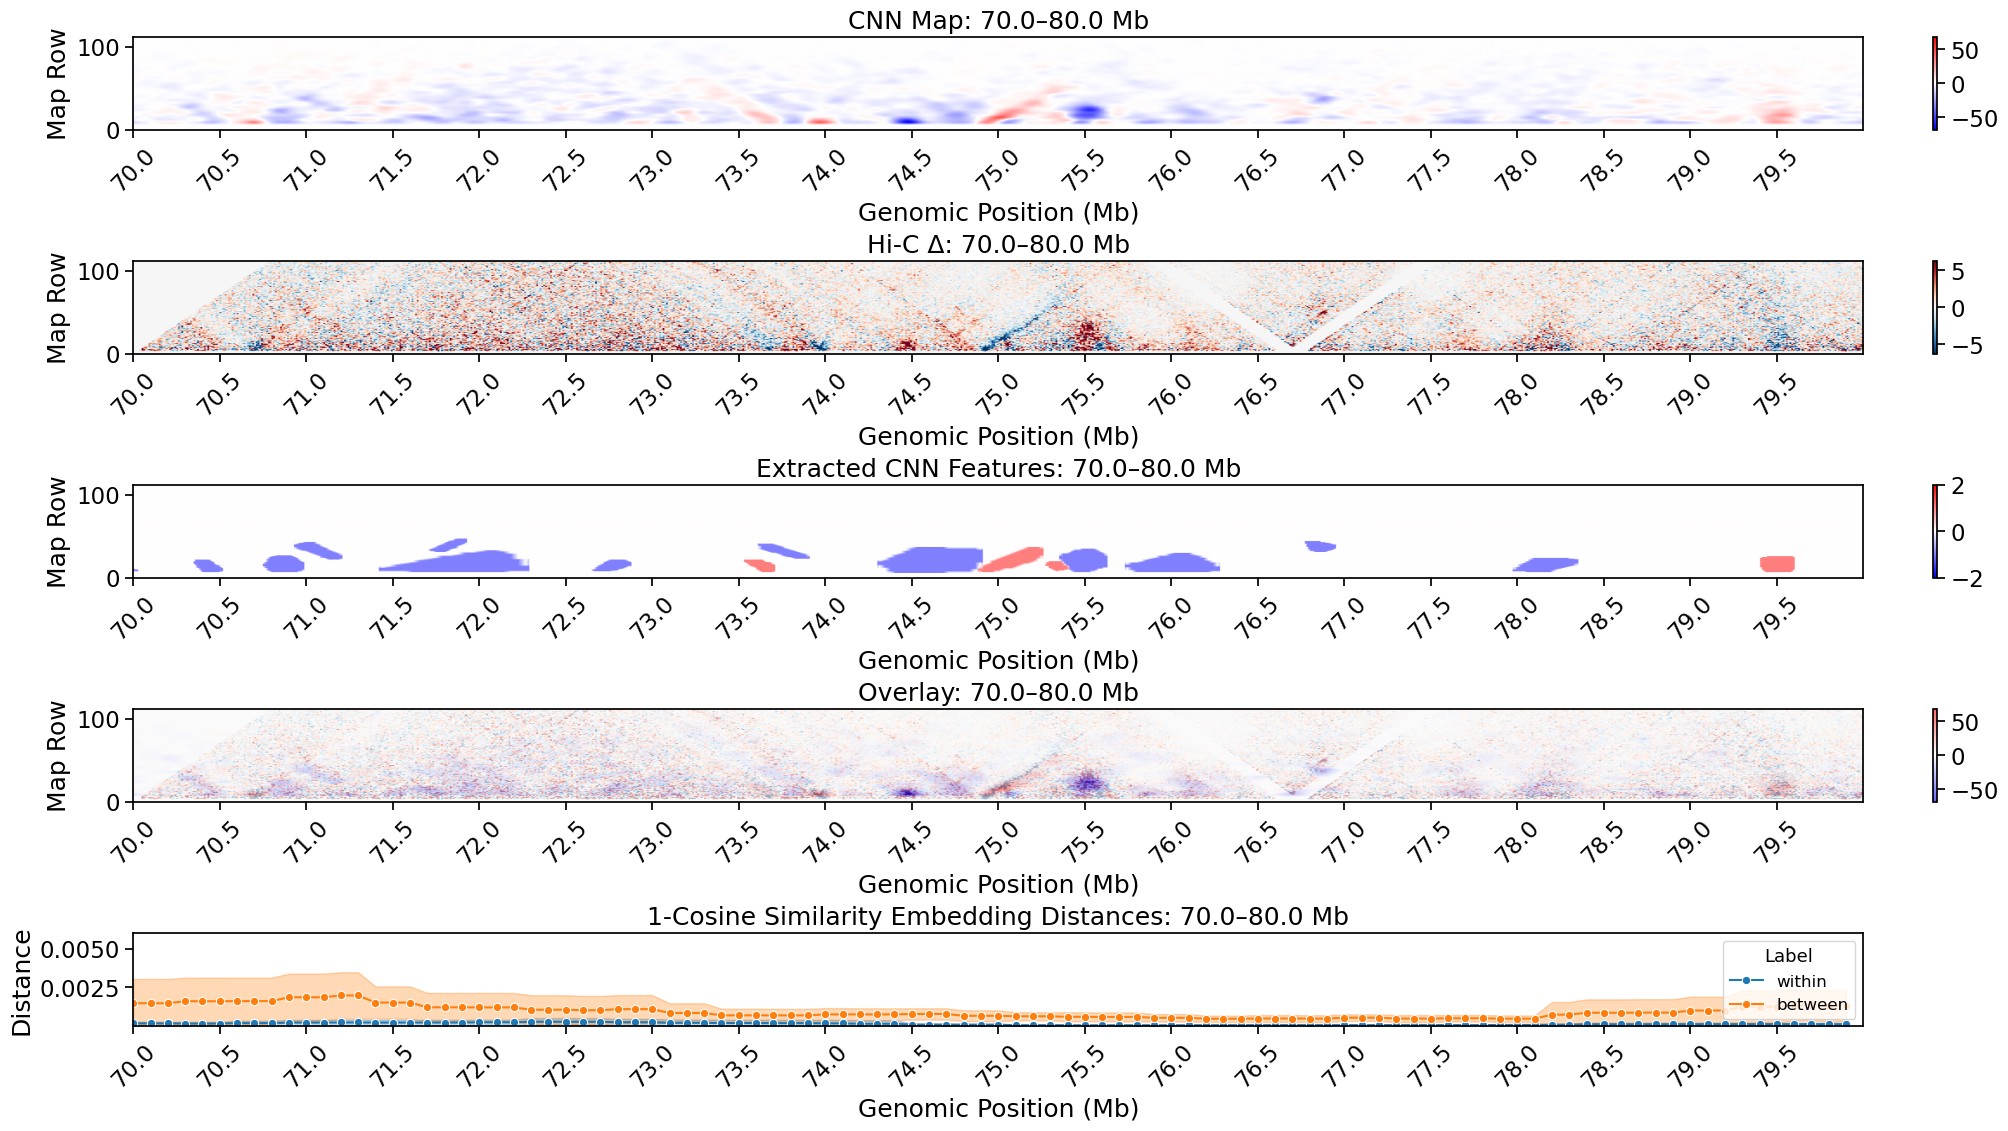

Plotting chunk 2: 80.0-84.0 Mb


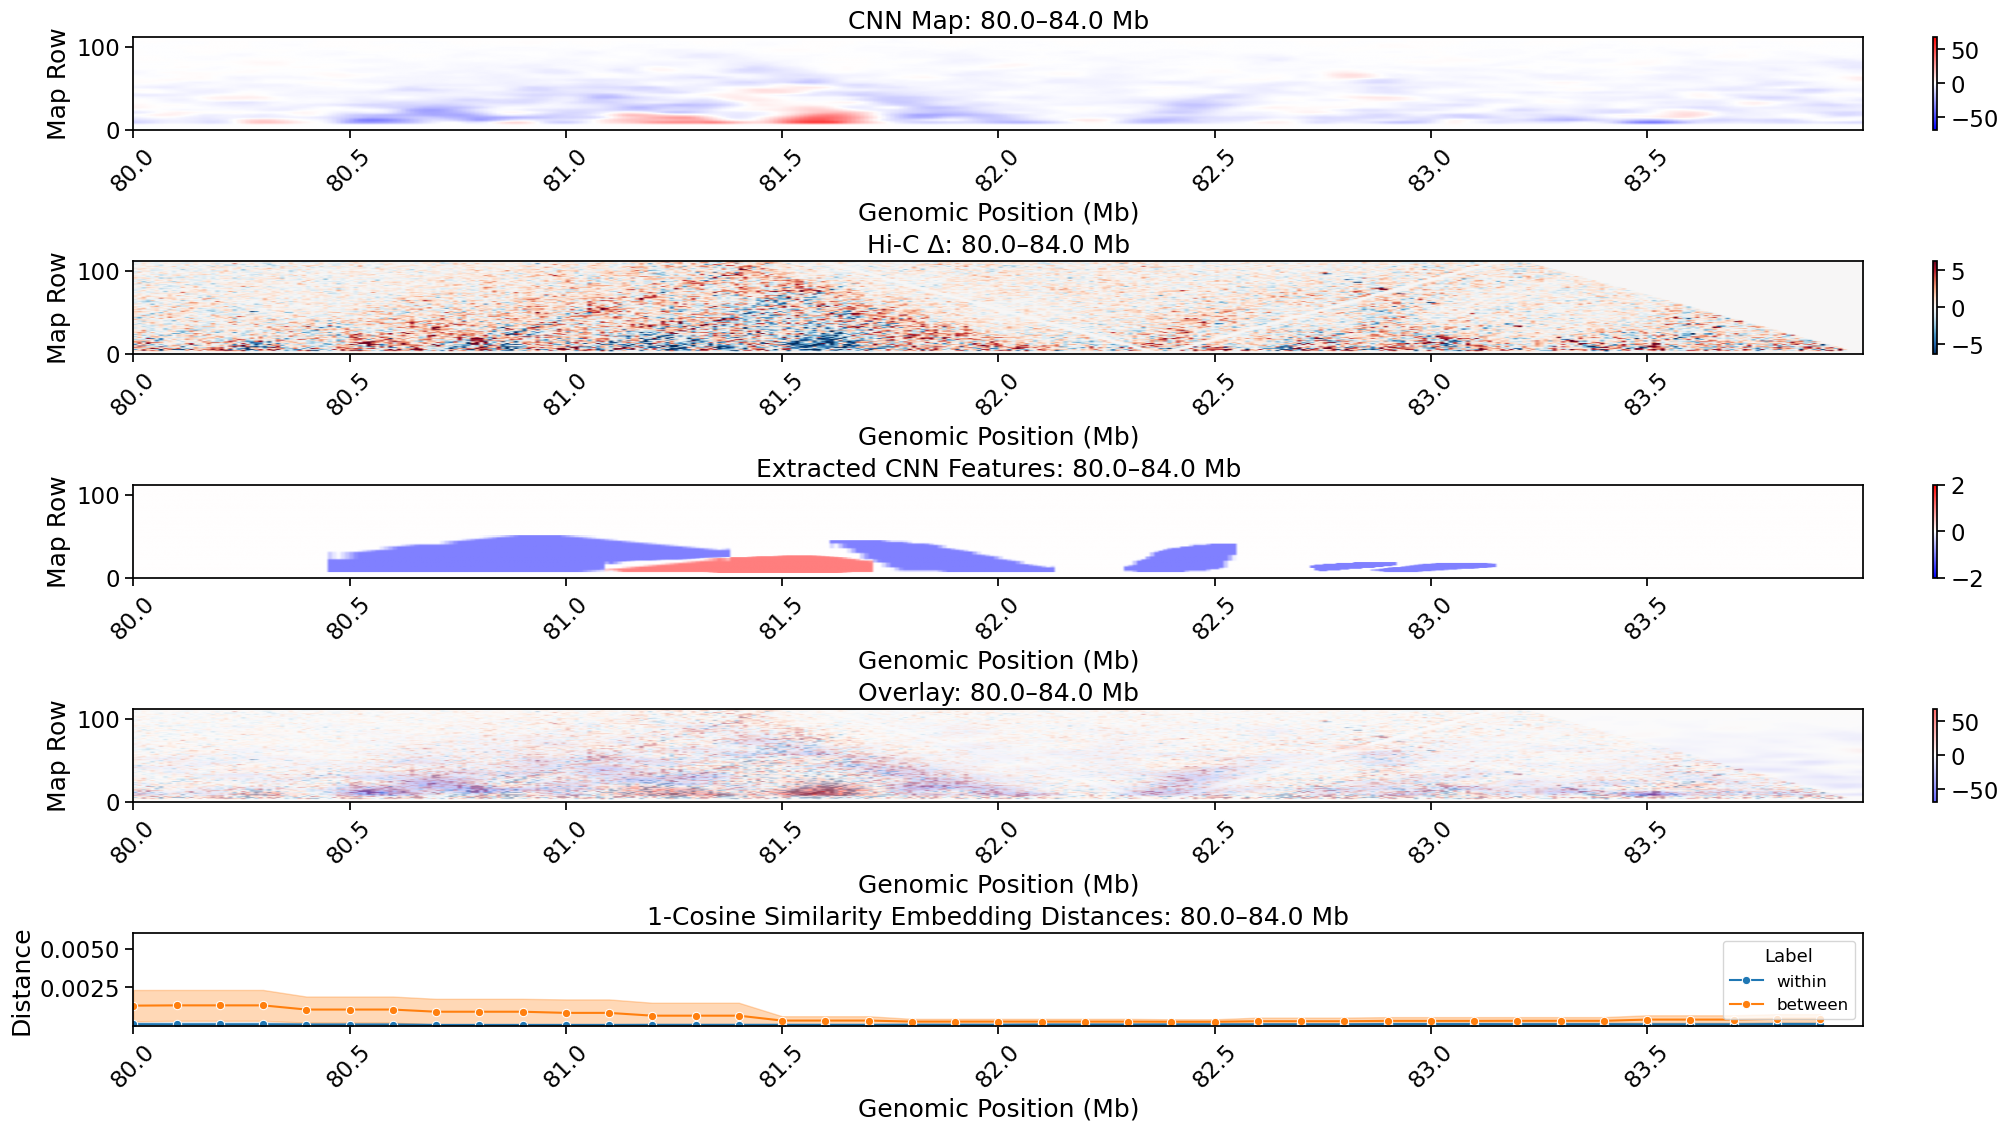

Completed plotting 2 chunks!


In [102]:
plot_hic_cnn_features(hic_files = hic_files,
    paired_maps = paxip_features_supcon.paired_maps,
    filter_features = paxip_supcon_different_filter_features[0],
    model_ckpt_path = model_checkpoint,
    mlhic_dataset = mlhic_dataset,
    distance_measure = "cosine",
    reference_genome = reference_genomes['mm9'],
    mb_start = 70.0,
    mb_end = 84.0,
    chrom = "chr18")

In [98]:

def plot_hic_cnn_features(
    hic_files,
    paired_maps, 
    filter_features,
    model_ckpt_path,
    mlhic_dataset,
    reference_genome,
    mb_start=None,
    mb_end=None,
    distance_measure="pairwise", 
    chrom="chr2",
    bin_size=10000,
    patch_len=224,
    position_stride=10,
    chunk_size=1000,
    plot_w=20
):
    """
    Plot chunked panels over a genomic Mb range instead of bin count.
    
    Parameters:
    -----------
    hic_files : dict
        Mapping "KO"/"WT" to lists of (label, path)
    paired_maps : HiCDatasetDec.paired_maps
        Paired maps from HiCDatasetDec
    filter_features : list
        List of extracted CNN features
    model_ckpt_path : str
        Path to checkpoint file for trained Siamese model
    test_hic_paths : list
        Loaded mlhic files
    reference_genome : str
        Key for reference_genomes dict
    mb_start : float, optional
        Start position in Mb (inclusive). If None, starts from chromosome beginning.
    mb_end : float, optional
        End position in Mb (exclusive). If None, goes to chromosome end.
    distance_measure : str, default pairwise
        Measure for embedding distance. The options are either "cosine" or "pairwise". Supcon works best with cosine while contrastive and triplet works best with pairwise
    chrom : str
        Chromosome string, e.g. "chr2"
    bin_size : int
        Hi-C resolution in bp
    patch_len : int, default 224
        Model patch length in bins
    position_stride : int, default 10
        Subsampling stride in bins
    chunk_size : int, default 1000
        Bins per plotting chunk
    plot_w : float, default 20
        Plot width in inches
    """
    
    # Set plot style and random seed
    plt.rcParams.update({"font.size": 12})
    random.seed(100)
    
    # Get chromosome length if mb_start/mb_end not provided
    if mb_start is None or mb_end is None:
        # Open first Hi-C file to get chromosome length
        first_file = hic_files["KO"][0][1] if "KO" in hic_files else hic_files["WT"][0][1]
        hic = hicstraw.HiCFile(first_file)
        chromosomes = hic.getChromosomes()
        
        # Find the target chromosome
        chrom_length = None
        for c in chromosomes:
            if c.name == chrom:
                chrom_length = c.length
                break
        
        if chrom_length is None:
            raise ValueError(f"Chromosome {chrom} not found in Hi-C file")
        
        # Set default range if not provided
        if mb_start is None:
            mb_start = 0.0
        if mb_end is None:
            mb_end = chrom_length / 1e6  # Convert bp to Mb
        
        print(f"Auto-detected chromosome {chrom} length: {chrom_length:,} bp ({mb_end:.1f} Mb)")
    
    # Convert MB range to genomic coordinates and bins
    start = int(mb_start * 1e6)
    end = int(mb_end * 1e6) 
    start_bin = start // bin_size
    end_bin = end // bin_size
    num_bins = end_bin - start_bin
    mb_range = mb_end - mb_start
    
    print(f"Analyzing {chrom}:{mb_start:.1f}-{mb_end:.1f} Mb")
    print(f"Bin range: {start_bin}-{end_bin} ({num_bins} bins)")
    
    # Create mask
    mask = np.tril(np.ones((num_bins, num_bins)), k=-6)
    
    def process_matrix(matrix, target_width):
        """Process Hi-C matrix with rotation and cropping"""
        matrix *= mask
        matrix_rot = rotate(matrix, angle=45, reshape=True, order=1)
        half_height = matrix_rot.shape[0] // 2
        matrix_cropped = matrix_rot[half_height:, :]
        if matrix_cropped.shape[1] != target_width:
            matrix_resized = resize(
                matrix_cropped,
                (matrix_cropped.shape[0], target_width),
                order=1,
                preserve_range=True
            )
        else:
            matrix_resized = matrix_cropped
        return matrix_resized

    def load_and_sum_replicates(file_list, target_width):
        """Load and sum Hi-C replicates"""
        summed = None
        for label, path in file_list:
            print(f"  Loading {label}...")
            hic = hicstraw.HiCFile(path)
            mzd = hic.getMatrixZoomData(chrom, chrom, "observed", "KR", "BP", bin_size)
            matrix = mzd.getRecordsAsMatrix(start, end - bin_size, start, end - bin_size)
            proc = process_matrix(matrix, target_width)
            summed = proc.copy() if summed is None else summed + proc
        return summed

    # Load and process Hi-C data
    print("Processing Hi-C data...")
    print("  KO condition:")
    ko_sum = load_and_sum_replicates(hic_files["KO"], num_bins)
    print("  WT condition:")
    wt_sum = load_and_sum_replicates(hic_files["WT"], num_bins)
    diff_matrix = ko_sum - wt_sum
    print(f"  Difference matrix shape: {diff_matrix.shape}")

    # CNN CONDITION MAP EXTRACTION
    def plot_conditions_map(paired_maps, chromosome_num, bin_start=0, bin_end=None, row_end=None):
        """Extract CNN condition map"""
        all_maps = paired_maps.get(chromosome_num)
        if all_maps is None:
            raise ValueError(f"No paired maps found for chromosome {chromosome_num}")
        cond_map = all_maps["conditions"]
        cond_sum = np.nansum(cond_map, axis=0)
        if bin_end is None: 
            bin_end = cond_sum.shape[1]
        if row_end is None: 
            row_end = cond_sum.shape[0]
        half_row = cond_sum.shape[0] // 2
        return cond_sum[half_row:row_end, bin_start:bin_end]
    
    # Extract chromosome number for paired_maps lookup
    chrom_num = chrom.replace("chr", "")
    
    print("Extracting CNN condition map...")
    cnn_cond_map = plot_conditions_map(
        paired_maps=paired_maps,
        chromosome_num=chrom_num,
        bin_start=start_bin,
        bin_end=start_bin + num_bins
    )
    print(f"CNN condition map shape: {cnn_cond_map.shape}")
    
    # Align difference matrix with CNN map
    icom_diff = diff_matrix[:cnn_cond_map.shape[0], :cnn_cond_map.shape[1]]
    print(f"Aligned difference matrix shape: {icom_diff.shape}")

    # MODEL DISTANCE CALCULATIONS
    def test_model(model, dataloader, patch_len=224):
        """Test Siamese model and return distances"""
        all_distances = []
        all_labels = []
        for _, (x1, x2, y) in enumerate(dataloader):
            y = y.float()
            with torch.no_grad():
                o1, o2 = model(x1, x2)
                if distance_measure.lower() == "cosine":     
                    dists = 1 - F.cosine_similarity(o1, o2)
                elif distance_measure.lower() == "pairwise":
                    dists = F.pairwise_distance(o1, o2)
            # Expand each distance/label for all bins in the patch
            expanded_dists = np.repeat(dists.cpu().numpy(), patch_len)
            expanded_labels = np.repeat(y.cpu().numpy(), patch_len)
            all_distances.append(expanded_dists)
            all_labels.append(expanded_labels)
        return np.concatenate(all_distances), np.concatenate(all_labels)

    # Load and test model
    print("Loading Siamese model...")
    model = models.SLeNet(mask=True)
    model.load_state_dict(torch.load(model_ckpt_path, map_location="cpu"))
    model.eval()
    
    print("Loading test datasets...")
    siamese = SiameseHiCDataset(mlhic_dataset, reference=reference_genome)
    def normalize_chrom(chrom):
        """Strip 'chr' if present to normalize chromosome names."""
        return chrom[3:] if chrom.startswith("chr") else chrom
    
    def subset_by_chromosome(dataset, target_chrom):
        # Normalize the target too
        target_chrom = normalize_chrom(target_chrom)
        indices = [
            i for i, (_, chrom) in enumerate(dataset.pos)
            if normalize_chrom(chrom) == target_chrom
        ]
        print(f"Found {len(indices)} samples for chromosome {target_chrom}")
        return Subset(dataset, indices)
    siamese_subset = subset_by_chromosome(siamese, chrom)
    dl = DataLoader(siamese_subset, batch_size=100, sampler=SequentialSampler(siamese_subset))

    print("Running model testing...")
    distances, labels_siam = test_model(model, dl, patch_len=patch_len)

    # Get genomic positions and expand them
    print("Processing genomic positions...")
    subset_indices = siamese_subset.indices  # Get original dataset indices

    # Use original dataset method
    pd_dict = siamese.get_genomic_positions(append="chr")
    
    # Now filter it with the chromosome-specific indices
    subset_pd_dict = {
        key: [val[i] for i in subset_indices]
        for key, val in pd_dict.items()
    }
    start_positions = subset_pd_dict["Start"]
    chromosomes = subset_pd_dict["Chromosome"]
    labels = siamese.labels

    # Sanity check
    assert len(start_positions) == len(distances) // patch_len, "Mismatch in number of patches"

    # Expand genomic positions
    expanded_starts = []
    expanded_chroms = []
    expanded_true_labels = []
    for chrom_val, start_pos, label in zip(chromosomes, start_positions, labels):
        for i in range(patch_len):
            expanded_starts.append(start_pos + i * bin_size)
            expanded_chroms.append(chrom_val)
            expanded_true_labels.append(label)

    # Construct DataFrame
    pos_df = pd.DataFrame({
        "Chromosome": expanded_chroms,
        "Start": expanded_starts,
        "distance": distances,
        "labels": expanded_true_labels,
        "label_siam": np.where(labels_siam==0, "within", "between")
    })

    # Filter for target chromosome and range
    pos_df = pos_df[pos_df["Chromosome"] == chrom]
    pos_df["bin_idx"] = ((pos_df["Start"] / bin_size) - start_bin).astype(int)
    pos_df = pos_df[(pos_df["bin_idx"] >= 0) & (pos_df["bin_idx"] < num_bins)]
    pos_df["Mb"] = pos_df["Start"] / 1e6

    # Subsample every nth bin for plotting
    print("Subsampling positions for plotting...")
    unique_positions = sorted(pos_df["Start"].unique())
    selected_positions = unique_positions[::position_stride]
    pos_df = pos_df[pos_df["Start"].isin(selected_positions)].reset_index(drop=True)
    print(f"Selected {len(pos_df)} positions for plotting")

    def get_xlabels(start_bin_chunk, end_bin_chunk, total_bins, start_mb, mb_range):
        """Generate x-axis labels for genomic coordinates"""
        start_mb_chunk = start_mb + (mb_range * start_bin_chunk / total_bins)
        end_mb_chunk = start_mb + (mb_range * end_bin_chunk / total_bins)
        tick_mbs = np.arange(np.ceil(start_mb_chunk * 2) / 2, end_mb_chunk, 0.5)
        tick_bins = ((tick_mbs - start_mb) / mb_range) * total_bins - start_bin_chunk
        return tick_bins, [f"{mb:.1f}" for mb in tick_mbs]

    def reconstruct_cnn_features(features, paired_maps, chromosome_num, pixel_size, num_bins):
        """Reconstruct CNN features canvas"""
        grouped = paired_maps.get(chromosome_num, None)
        if grouped is None:
            raise RuntimeError(f"No CNN maps for chromosome {chromosome_num}")
        rep_map = grouped["replicate"]
        canvas_bins = len(rep_map[0][0])
        canvas = np.zeros((pixel_size, canvas_bins), dtype=np.float32)
        
        for feat in features:
            idx, patch, orig_dims, y0, count, pos_or_neg, score, (chrom_feat, i0, i1, j0, j1) = feat
            if chrom_feat != chromosome_num:
                continue
            patch_up = resize(
                patch.astype(float), output_shape=orig_dims,
                order=1, preserve_range=True, anti_aliasing=False
            )
            yslice = slice(i0, i0 + orig_dims[0])
            xslice = slice(j0, j0 + orig_dims[1])
            if yslice.stop > pixel_size or xslice.stop > canvas_bins:
                continue
            canvas[yslice, xslice] += (patch_up if pos_or_neg == 0 else -patch_up)
        return canvas

    # Reconstruct CNN features
    print("Reconstructing CNN features...")
    height, width = cnn_cond_map.shape
    actual_height = icom_diff.shape[0]
    
    cnn_feats = reconstruct_cnn_features(
        features=filter_features,
        paired_maps=paired_maps,
        chromosome_num=chrom_num,
        pixel_size=actual_height,
        num_bins=width
    )
    print(f"CNN features canvas shape: {cnn_feats.shape}")

    # Calculate plot dimensions
    plot_height_per_plot = plot_w * (actual_height / chunk_size)
    fig_height = 5 * plot_height_per_plot  # 5 subplots
    
    dist_min, dist_max = pos_df["distance"].min(), pos_df["distance"].max()

    # PLOTTING
    print("Starting plotting...")
    plot_count = 0
    
    for bs in range(0, width, chunk_size):
        be = min(bs + chunk_size, width)
        w = be - bs
        if w <= 0:
            continue

        # Calculate Mb range for this chunk
        mb_s = mb_start + mb_range * bs / width
        mb_e = mb_start + mb_range * be / width

        print(f"Plotting chunk {plot_count + 1}: {mb_s:.1f}-{mb_e:.1f} Mb")

        # Extract data chunks
        cnn_chunk = cnn_cond_map[:actual_height, bs:be]
        hic_chunk = icom_diff[:actual_height, bs:be]
        
        # Extract feature chunk (adjust indexing based on your feature coordinate system)
        feat_start_idx = int(mb_s * 100)  # Adjust multiplier as needed
        feat_end_idx = int(mb_e * 100)
        if feat_end_idx <= cnn_feats.shape[1]:
            feat_chunk = cnn_feats[:, feat_start_idx:feat_end_idx]
        else:
            # Pad or truncate as needed
            feat_chunk = np.zeros((actual_height, w))
            available_width = min(w, cnn_feats.shape[1] - feat_start_idx)
            if available_width > 0:
                feat_chunk[:, :available_width] = cnn_feats[:, feat_start_idx:feat_start_idx + available_width]

        # Filter position data for this chunk
        subdf = pos_df[(pos_df["bin_idx"] >= bs) & (pos_df["bin_idx"] < be)].copy()
        subdf["x_bin"] = subdf["bin_idx"] - bs

        # Create 5 subplots - Remove sharex=True to allow independent x-axis labeling
        fig, axs = plt.subplots(
            5, 1,
            figsize=(plot_w, fig_height),
            constrained_layout=True
        )
        
        xticks, xtick_labels = get_xlabels(bs, be, width, mb_start, mb_range)

        # 1) CNN Map
        im0 = axs[0].imshow(
            cnn_chunk, cmap='bwr', origin='lower', aspect='auto',
            vmin=-np.nanmax(np.abs(cnn_cond_map)),
            vmax=np.nanmax(np.abs(cnn_cond_map)),
            extent=[0, w, 0, actual_height]
        )
        axs[0].set_title(f"CNN Map: {mb_s:.1f}–{mb_e:.1f} Mb")
        axs[0].set_ylabel("Map Row")
        axs[0].set_ylim(0, actual_height)
        axs[0].set_xticks(xticks)
        axs[0].set_xticklabels(xtick_labels, rotation=45)
        axs[0].set_xlabel("Genomic Position (Mb)")
        plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

        # 2) Hi‑C Δ
        im1 = axs[1].imshow(
            hic_chunk, cmap='RdBu_r', origin='lower', aspect='auto',
            vmin=-np.percentile(np.abs(icom_diff), 99),
            vmax=np.percentile(np.abs(icom_diff), 99),
            extent=[0, w, 0, actual_height]
        )
        axs[1].set_title(f"Hi‑C Δ: {mb_s:.1f}–{mb_e:.1f} Mb")
        axs[1].set_ylabel("Map Row")
        axs[1].set_ylim(0, actual_height)
        axs[1].set_xticks(xticks)
        axs[1].set_xticklabels(xtick_labels, rotation=45)
        axs[1].set_xlabel("Genomic Position (Mb)")
        plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

        # 3) Extracted CNN Features
        im_feat = axs[2].imshow(
            feat_chunk, cmap='bwr', origin='lower', aspect='auto',
            vmin=-np.nanmax(np.abs(cnn_feats)) if np.nanmax(np.abs(cnn_feats)) > 0 else -1,
            vmax=np.nanmax(np.abs(cnn_feats)) if np.nanmax(np.abs(cnn_feats)) > 0 else 1,
            extent=[0, w, 0, actual_height]
        )
        axs[2].set_title(f"Extracted CNN Features: {mb_s:.1f}–{mb_e:.1f} Mb")
        axs[2].set_ylabel("Map Row")
        axs[2].set_ylim(0, actual_height)
        axs[2].set_xticks(xticks)
        axs[2].set_xticklabels(xtick_labels, rotation=45)
        axs[2].set_xlabel("Genomic Position (Mb)")
        plt.colorbar(im_feat, ax=axs[2], fraction=0.046, pad=0.04)

        # 4) Overlay
        axs[3].imshow(
            hic_chunk, cmap='RdBu_r', origin='lower', aspect='auto',
            vmin=-np.percentile(np.abs(icom_diff), 99),
            vmax=np.percentile(np.abs(icom_diff), 99),
            extent=[0, w, 0, actual_height], alpha=1.0
        )
        im2 = axs[3].imshow(
            cnn_chunk, cmap='bwr', origin='lower', aspect='auto',
            vmin=-np.nanmax(np.abs(cnn_cond_map)),
            vmax=np.nanmax(np.abs(cnn_cond_map)),
            extent=[0, w, 0, actual_height], alpha=0.6
        )
        axs[3].set_title(f"Overlay: {mb_s:.1f}–{mb_e:.1f} Mb")
        axs[3].set_ylabel("Map Row")
        axs[3].set_ylim(0, actual_height)
        axs[3].set_xticks(xticks)
        axs[3].set_xticklabels(xtick_labels, rotation=45)
        axs[3].set_xlabel("Genomic Position (Mb)")
        plt.colorbar(im2, ax=axs[3], fraction=0.046, pad=0.04)

        # 5) Pairwise Distances
        if len(subdf) > 0:
            sns.lineplot(
                data=subdf, x="x_bin", y="distance", hue="label_siam",
                ax=axs[4], ci="sd", estimator="mean", marker="o",
                err_kws={"alpha": 0.3}
            )
        if distance_measure.lower() == "cosine":     
            axs[4].set_title(f"1-Cosine Similarity Embedding Distances: {mb_s:.1f}–{mb_e:.1f} Mb")
        elif distance_measure.lower() == "pairwise":
            axs[4].set_title(f"Pairwise Similarity Embedding Distances: {mb_s:.1f}–{mb_e:.1f} Mb")
        axs[4].set_xlabel("Genomic Position (Mb)")
        axs[4].set_ylabel("Distance")
        axs[4].set_xticks(xticks)
        axs[4].set_xticklabels(xtick_labels, rotation=45)
        axs[4].set_xlim(0, w)
        axs[4].set_ylim(dist_min, dist_max)
        axs[4].legend(title="Label", fontsize=12, title_fontsize=13, loc="upper right")

        # Set x-axis limits for all subplots
        for ax in axs:
            ax.set_xlim(0, w)

        plt.show()
        plot_count += 1
    
    print(f"Completed plotting {plot_count} chunks!")

### Inspect individual features

(20, 20)
(13, 65)
18345
18410
1
1


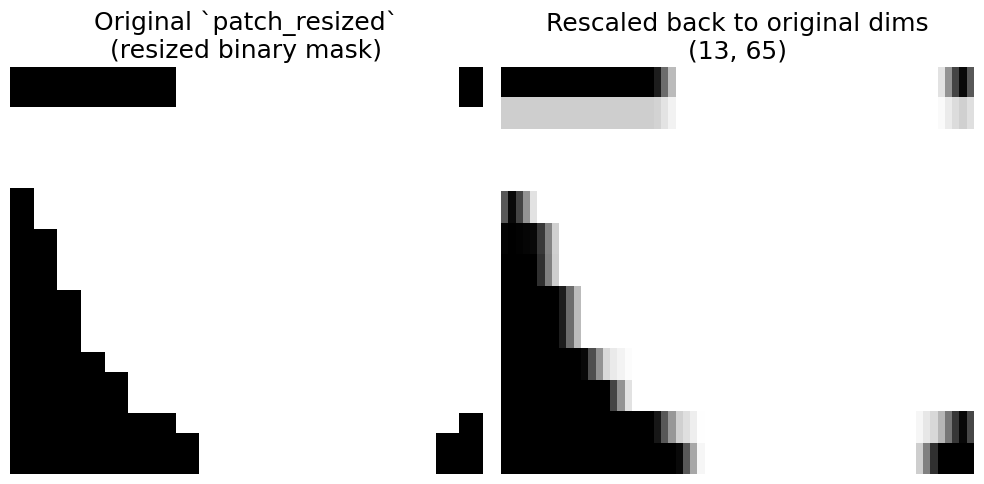

In [103]:


# Extract one feature
feat = paxip_supcon_different_filter_features[0][121]

(
    feature_index,        # 0
    patch_resized,        # 1: binary mask resized (e.g. 20x20)
    original_dims,        # 2: target shape to resize back to (e.g. 18x16)
    y_start,              # 3
    label_count,          # 4
    pos_or_neg,           # 5
    score,                # 6
    [chrom, y0, y1, x0, x1]  # 7
) = feat

print(patch_resized.shape)
print(original_dims)
print(x0)
print(x1)
print(pos_or_neg)
print(chrom)
# Rescale to original shape
patch_rescaled = resize(
    patch_resized.astype(float),
    output_shape=original_dims,
    order=1, preserve_range=True, anti_aliasing=False
)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(patch_resized, cmap='gray', aspect='auto')
axes[0].set_title("Original `patch_resized`\n(resized binary mask)")
axes[0].axis('off')

axes[1].imshow(patch_rescaled, cmap='gray', aspect='auto')
axes[1].set_title(f"Rescaled back to original dims\n{original_dims}")
axes[1].axis('off')

plt.tight_layout()
plt.show()


### Do some clustering! 

In [108]:
filter_index=["all"]
list_of_images = []
for i,nfilter in enumerate(filter_index):
    for name, features in [("PAXIPKO",paxip_supcon_different_filter_features)]:
        curr=[(img_mets[1])*np.max(img_mets[1]) for img_mets in features[i]]
        list_of_images.extend(curr)

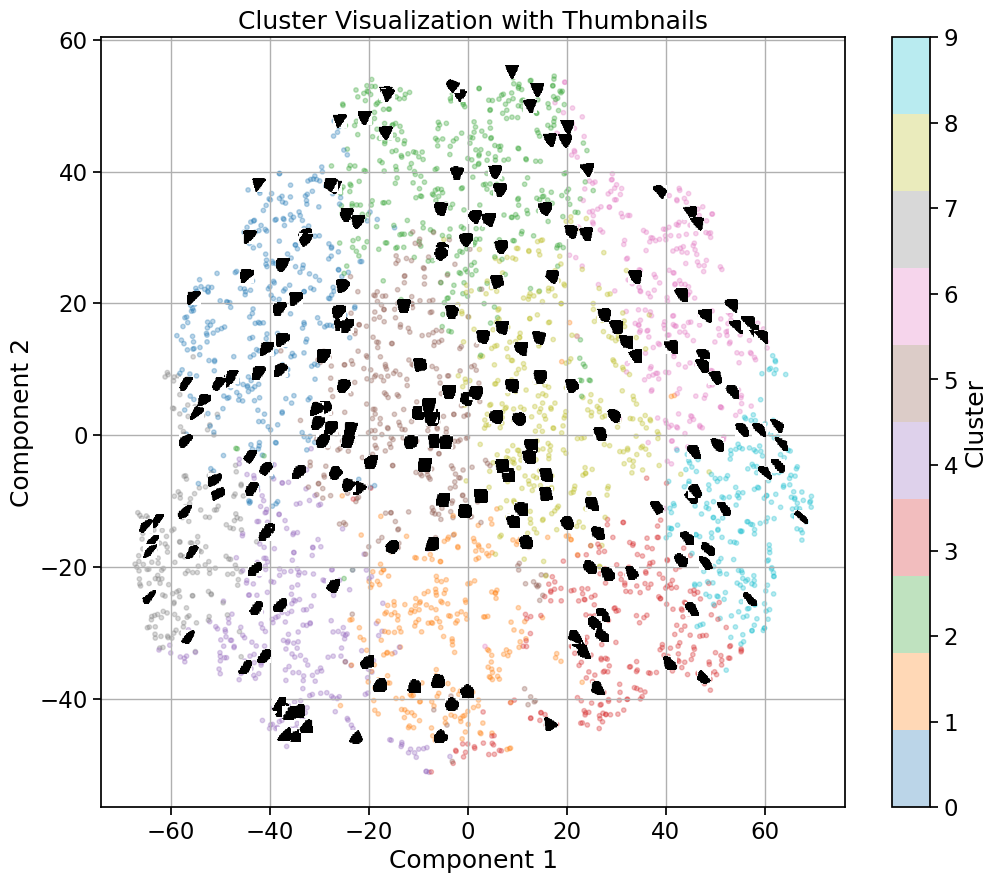

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# ==== CLUSTERING ====
X_train = np.array(list_of_images)
flat_X = X_train.reshape(len(X_train), -1)

k = 10
kmeans = KMeans(n_clusters=k, random_state=40).fit(flat_X)
labels = kmeans.labels_

# ==== DIMENSIONALITY REDUCTION ====
# PCA (faster)
#pca = PCA(n_components=2)
#reduced = pca.fit_transform(flat_X)

# # Or use t-SNE instead (slower, better local structure)
tsne = TSNE(n_components=2, random_state=40, perplexity=30)
reduced = tsne.fit_transform(flat_X)

# ==== PLOTTING ====
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Cluster Visualization with Thumbnails")

# Show colored points
scatter = ax.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=10, alpha=0.3)

# Overlay a subset of the images
for i in range(0, len(X_train), max(1, len(X_train)//200)):  # limit to avoid clutter
    image = X_train[i]
    im = OffsetImage(image, zoom=0.5, cmap='Greys')
    ab = AnnotationBbox(im, reduced[i], frameon=False)
    ax.add_artist(ab)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.colorbar(scatter, ticks=range(k), label="Cluster")
plt.show()
